### Pipeline


#### Only Ubuntu/Linux/Debian

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
print(sys.path)

['/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dinhmanh/nlp/.venv/lib/python3.8/site-packages', '/usr/local/lib/python3.8/site-packages']


In [1]:
import pandas as pd
import string
import re
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from transformers import pipeline
import py_vncorenlp
import os
# from CocCocTokenizer import PyTokenizer

d:\Tools\Miniconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Ghi nhớ thư mục gốc ngay từ đầu
PROJECT_ROOT = os.getcwd()
print("Thu mục gốc:", PROJECT_ROOT)

Thu mục gốc: d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\pre-processing


In [3]:
ABSOLUTE_MODEL_PATH = os.path.abspath("../attribute_extractor/vncorenlp")
print("Using model path:", ABSOLUTE_MODEL_PATH)

# Khởi tạo model từ thư mục local
vncorenlp_model = py_vncorenlp.VnCoreNLP(save_dir=ABSOLUTE_MODEL_PATH, max_heap_size="-Xmx2g")

Using model path: d:\School\4thYear\2ndSemester\NLP\Comment-Sentiment-Analysis\attribute_extractor\vncorenlp


### Khởi tạo CorrectSpelling

In [4]:
os.path.join(PROJECT_ROOT, "vietnamese-correction-v2")

'd:\\School\\4thYear\\2ndSemester\\NLP\\Comment-Sentiment-Analysis\\pre-processing\\vietnamese-correction-v2'

In [5]:
corrector = pipeline("text2text-generation", model=os.path.join(PROJECT_ROOT, "vietnamese-correction-v2"))

Device set to use cuda:0


### Làm sạch dữ liệu (xoá hàng comment trống hoặc nan)


In [18]:
df = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"))

In [19]:
df.shape

(2413, 4)

In [20]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file
534,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
535,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
536,iphone-15-plus,NaN,4,ratings\iphone-15-plus.csv
537,iphone-15-plus,NaN,5,ratings\iphone-15-plus.csv
538,iphone-15-plus,NaN,1,ratings\iphone-15-plus.csv
...,...,...,...,...
2288,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2289,xiaomi-redmi-a3,NaN,4,ratings\xiaomi-redmi-a3.csv
2290,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv
2291,xiaomi-redmi-a3,NaN,5,ratings\xiaomi-redmi-a3.csv


In [21]:
# Xoá hàng chứa comment trống hoặc nan
df = df[df["comment"].str.len() > 1]

In [22]:
df.shape

(2313, 4)

In [23]:
df[~df["comment"].notna()]

,product_id,comment,rating,source_file


In [25]:
df.to_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings.csv"), index=False)

In [12]:
before_total_words = df['comment'].apply(lambda x: len(x.split())).sum()
before_total_words

53287

### Pipeline xử lý cho văn bản tiếng Việt


In [26]:
class VietnamesePreprocessing:
    def __init__(self):
        # Load Vietnamese stopwords
        with open(
            os.path.join(PROJECT_ROOT, "../data/vietnamese.txt"), "r", encoding="utf-8"
        ) as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open(
            os.path.join(PROJECT_ROOT, "../data/vi-abbreviations.json"),
            "r",
            encoding="utf-8",
        ) as file:
            self.abbreviations = json.load(file)

    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x)
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        print("Before:", x)
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_abbreviations(x)
        x = self.correct_spelling(x)
        x= self.to_lower(x)
        
        print("After: ", x)
        return x


preprocessor = VietnamesePreprocessing()

### Chia ra xử lý từng batch dữ liệu

In [27]:
df_part1 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part1.csv"))
df_part2 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part2.csv"))
df_part3 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part3.csv"))
df_part4 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part4.csv"))
df_part5 = pd.read_csv(os.path.join(PROJECT_ROOT, "../data/raw_data/phone_ratings_part5.csv"))

In [28]:
for idx, row in df_part1.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part1.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: Đừng mua, ko có linh kiện.
After:  đừng mua, không có linh kiện.
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo vui nó báo hiện tn cuộc gọi buồn thì nó im ru hên ít sài zalo chứ sài nhiều chắc vức
After:  máy sao cũng được ghét nhất cái zalo, vui nó báo hiện tên cuộc gọi, buồn thì nó im ru, hên ít sài zalo chứ sài nhiều chắc tức.
=====> Processing row 3
Before: Chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này mượt hơn nhiều 680 ở SS a05s vợ đag dùng
After:  chiếc điện thoại mỏng nhất tôi từng dùng, cũng là chip 680 trên máy này, mượt hơn nhiều 680 ở samsung a05s vợ đang dùng.
=====> Processing row 4
Before: sao hôm tôi mua lại ko dc tặng tai nghe như trong giới thiệu nhỉ hôm đấy tôi cũng có xem thấy khuyến mãi
After:  sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ, hôm đấy tôi cũng có xem thấy khuyến mãi.
=====> Processing row 5
Before: E Mua đc 1 tuần trả lại mất bao nhiêu % ạ
After:  e

In [35]:
for idx, row in df_part2.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part2.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: Sạc 25 lần tuột 1% pin kém quá
After:  sạc 25 lần tuột 1% pin kém quá!
=====> Processing row 2
Before: Màu xanh lá ,96% bán lại bao nhiêu ạ
After:  màu xanh lá , 96% bán lại bao nhiêu ạ?
=====> Processing row 3
Before: Sai mới 4thang mà hao hết 3% pin hối hận
After:  sai mới 4 tháng mà hao hết 3% pin, hối hận.
=====> Processing row 4
Before: Mới mua chưa đc 1tháng, dùng cũng mướt nhưng lâu lâu đag vào ứng dụng và treo và tự thoát ra, ko hỉu lý do
After:  mới mua chưa được 1 tháng, dùng cũng mướt nhưng lâu lâu đang vào ứng dụng và treo và tự thoát ra, không hiểu lý do.
=====> Processing row 5
Before: Mới sài có 8tháng pin còn 95%. Quá bưa.
After:  mới sài có 8 tháng pin còn 95%. quá bưa.
=====> Processing row 6
Before: Tôi mua được 4 tháng, giờ màn hình đổ mực. Khi nhân viên kiểm tra báo Tôi có cấn thân máy. Tôi không thấy. Nhưng tôi vẫn đồng ý,nhưng lại báo hãng có cấn màn hình và hãng báo không bảo hành. Tôi đã khiếu nại và đang chờ giải quyết. Không bi

In [36]:
df_part2[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part2.csv"), index=False)

In [37]:
for idx, row in df_part3.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part3.at[idx, "comment_clean_stage1"] = preprocessor(row["comment"])  # Apply preprocessing

=====> Processing row 1
Before: Ok
After:  ok!
=====> Processing row 2
Before: Nghe rõ chữ to
After:  nghe rõ chữ to.
=====> Processing row 3
Before: Sử dụng tốt, rất ok
After:  sử dụng tốt, rất ok.
=====> Processing row 4
Before: Bị lôi mới đổi lại cái moi
After:  bị lôi mới đổi lại cái mới.
=====> Processing row 5
Before: Rất tốt
After:  rất tốt.
=====> Processing row 6
Before: Tốt
After:  tốt.
=====> Processing row 7
Before: Ok
After:  ok!
=====> Processing row 8
Before: Chưa sạc lần nào cục sạc đã hư
After:  chưa sạc lần nào cục sạc đã hư.
=====> Processing row 9
Before: Mua lại máy đã qua sử dụng nói chung pin cũng ổn. Nhiều người đánh giá nói nhanh hết pin mặc dù không nghe gọi gì nhiều theo mình nghĩ chắc là tùy chiếc nhanh hết pin có chiếc không. Cũng tùy theo cách sạc điện thoại nữa. Đánh giá chung thì máy loa to nghe gọi rõ. Phím bấm nhẹ. Tuy nhiên máy chỉ có thể chụp ảnh và xem ảnh nghe nhạc chứ không xem được video và quay phim như thông số trên website của ĐMX đề cập. Một 

In [38]:
df_part3[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part3.csv"), index=False)

### Chạy lại pipeline (không có bước spell check)

In [11]:
df = pd.read_csv("../data/phone_ratings_cleaned.csv")
df= df[df["comment"].str.len() >1]

In [ ]:
class VietnamesePreprocessingWithoutSpellCheck:
    def __init__(self):
        # Load Vietnamese stopwords
        with open("../data/vietnamese.txt", "r", encoding="utf-8") as file:
            self.stop_words = set(word.strip() for word in file.read().splitlines())
        with open("../data/vi-abbreviations.json", "r", encoding="utf-8") as file:
            self.abbreviations = json.load(file)
        with open("../data/compound_words.txt", "r", encoding="utf-8") as file:
            self.compound_words = set(word.strip() for word in file.read().splitlines())
        # self.cocCocTokenizer = PyTokenizer(load_nontone_data=True)
        self.vncorenlp_model = vncorenlp_model


    def clean(self, x: str) -> str:
        """Clean the text by removing unwanted characters or patterns."""
        x = re.sub(r"\s+", " ", x) # replace multiple spaces with a single space

        # Replace '10d', '10đ', '10 điểm' to 'tốt' if > 8, 'khá' if > 5, 'tệ' if <= 5 (0-5)
        x = re.sub(r"\b(\d{1,2})(d|đ)\b", lambda match: "tốt" if int(match.group(1)) > 8 else "tạm" if int(match.group(1)) > 4 else "tệ", x) 

        x = re.sub(r"\b0", "", x)  # remove digit 0 at the beginning

        # Remove phone number
        x = re.sub(r"(\d{10})", "", x) # remove phone number vietnam like 0954223654, 0856452325, 0123456789
        x = re.sub(r"(xx\s*){2,}", "", x) # remove phone number vietnam like xxx223654 hay 0905***654
        x = re.sub(r"(\*\s*)+", "", x)
        x = re.sub(r"\b\d+[xX\*]+\d+\b", "", x)  # Xoá các dãy số có chứa x hoặc *

        x = re.sub(r"\b[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b", "", x) # remove email
        x = re.sub(r"\b\d+\b", lambda match: "" if int(match.group(0)) >= 100 else match.group(0), x) # remove number stand alone
        
        x = re.sub(r"\b\d+(?:\.\d+)?(tr\d+|tr|k)\b", "", x) # Remove numbers >= 100 or numbers with 'tr' or 'k' (1tr5, 130k, 11940k)
        x = re.sub(r"\b\d+(?:\.\d+)?tr\d+(?:\.\d+)?k\b", "", x) # Remove like that 11tr990k

        # Split x% to x % example 70% to 70 %
        x = re.sub(r"(\d+)%", r"\1 %", x)
        x = re.sub(r"\s+", " ", x) # replace multiple spaces with a single space
        x = x.strip()  # Remove leading/trailing spaces
        return x

    def to_lower(self, x: str) -> str:
        """Convert all text to lowercase."""
        return x.lower()

    def delete_punctuation(self, x: str) -> str:
        """Remove punctuation from the text."""
        return x.translate(str.maketrans("", "", string.punctuation))

    def tokenize_text(self, x: str) -> list:
        """Tokenize the text into words."""
        return " ".join(vncorenlp_model.word_segment(x))

    def delete_stop_words(self, x: str) -> str:
        """Remove stopwords from the text."""
        return " ".join([word for word in x.split() if word not in self.stop_words])
    
    def replace_compound_words(self, x: str) -> str:
        # Thay các từ trong comment có compound đọc được từ file compound_words.txt
        for word in self.compound_words:
            x = x.replace(word, word.replace(" ", "_"))
        return x

    def replace_abbreviations(self, x: str) -> str:
        """Replace abbreviations in the text using the loaded dictionary."""
        return " ".join([self.abbreviations.get(word, word) for word in x.split()])

    def correct_spelling(self, x: str) -> str:
        """Correct spelling using the loaded model."""
        return corrector(x, max_length=2500)[0]["generated_text"]

    def __call__(self, x: str):
        """Apply the preprocessing pipeline to the input text."""
        before_x = x
        x = self.clean(x)
        x = self.to_lower(x)
        x = self.replace_abbreviations(x)
        x = self.delete_punctuation(x)
        x = self.replace_compound_words(x)
        x = self.tokenize_text(x)
        x = self.delete_stop_words(x)

        if before_x != x:
            print("Before:", before_x)
            print("After:", x)
        return x
    

without_spellcheck_preprocessor = VietnamesePreprocessingWithoutSpellCheck()

=====> Processing row 1
Before: đừng mua không có linh kiện
After: đừng mua không linh_kiện
=====> Processing row 2
Before: máy sao cũng được ghét nhất cái zalo vui nó báo hiện tên cuộc gọi
After: máy ghét zalo vui báo hiện cuộc_gọi
=====> Processing row 3
Before: chiếc điện thoại mỏng nhất tôi từng dùng cũng là chip trên máy này mượt hơn
After: điện_thoại mỏng chip máy mượt
=====> Processing row 4
Before: sao hôm tôi mua lại không được tặng tai nghe như trong giới thiệu nhỉ hôm đấy
After: hôm mua không tặng tai giới_thiệu hôm đấy
=====> Processing row 5
Before: em mua được tuần trả lại mất bao nhiêu ạ
After: mua tuần trả bao nhiêu
=====> Processing row 6
Before: thế giới di động có cường lực của honor không ạ
After: thế_giới di_động cường_lực honor không
=====> Processing row 7
Before: không có nhưng rất tiếc honor quá lạc hậu so với nhiều hãng hiệu năng tạm
After: không tiếc honor lạc_hậu hãng hiệu_năng tạm
=====> Processing row 8
Before: mua online bên này báo ngoài tp ra thì hàng k

In [ ]:
for idx, row in df_part1.iterrows():
    print(f"=====> Processing row {idx + 1}")
    df_part1.at[idx, "comment_clean_stage2"] = without_spellcheck_preprocessor(row["comment_clean_stage1"])  # Apply preprocessing

In [ ]:
df_part1[["product_id", "comment", "comment_clean_stage1", "rating"]].to_csv(os.path.join(PROJECT_ROOT, "../data/processed_data/phone_ratings_part1.csv"), index=False)

In [13]:
result = preprocessor("vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn")
print(result)

Before: vuốt mượt mà pin trâu đủ dùng 8h online 4g liên tục camera chụp ban đêm tốt màng hình có độ tương phản rõ nét loa ngoài nghe nhạc hay có phiên bản bộ nhớ 256gb thoải mái lưu trữ ảnh và ứng dụng đối với riêng mình thì samsung luôn lắng nghe phát triển để phù hợp từng khách hàng từ bình dân đến cao cấp mình luôn
After: vuốt mượt_mà pin trâu 8 h online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản nét loa nhạc phiên_bản bộ_nhớ 256 gb thoải_mái lưu_trữ ảnh ứng_dụng đối samsung lắng_nghe phát_triển khách_hàng bình_dân cao_cấp
vuốt mượt_mà pin trâu 8 h online 4g liên_tục camera chụp ban_đêm tốt màng hình độ tương_phản nét loa nhạc phiên_bản bộ_nhớ 256 gb thoải_mái lưu_trữ ảnh ứng_dụng đối samsung lắng_nghe phát_triển khách_hàng bình_dân cao_cấp


### Phân tích số lượng từ


In [14]:
df.head()

,product_id,comment,comment_clean,rating
0,honor-x8b,đừng mua không có linh kiện,đừng mua không linh_kiện,1
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,máy ghét zalo vui báo hiện cuộc_gọi,3
2,honor-x8b,chiếc điện thoại mỏng nhất tôi từng dùng cũng ...,điện_thoại mỏng chip máy mượt,5
3,honor-x8b,sao hôm tôi mua lại không được tặng tai nghe n...,hôm mua không tặng tai giới_thiệu hôm đấy,4
4,honor-x8b,em mua được tuần trả lại mất bao nhiêu ạ,mua tuần trả bao nhiêu,3


In [15]:
df.shape

(2308, 4)

In [16]:
after_total_words = df['comment_clean'].apply(lambda x: len(x.split())).sum()
after_total_words

24825

### Check lại data sau khi xử lý dữ liệu

![image.png](../assets/illustration/incorrect-stopwords.png)


In [17]:
df[df["comment_clean"].apply(lambda x: len(x) == 0)]

,product_id,comment,comment_clean,rating


In [18]:
df = df[df["comment_clean"].str.len() > 1]

In [19]:
df[df["comment_clean"].apply(lambda x: len(x) == 0)]

,product_id,comment,comment_clean,rating


Check lại thì thấy một số từ không nên xem là stopword như "tốt"


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2308 entries, 0 to 2307
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     2308 non-null   object
 1   comment        2308 non-null   object
 2   comment_clean  2308 non-null   object
 3   rating         2308 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 72.2+ KB


In [21]:
df["word_count"] = df["comment_clean"].astype(str).apply(lambda x: len(x.split()))

In [22]:
df[["comment_clean", "word_count"]].sort_values(
    by="word_count", ascending=False
).head()

,comment_clean,word_count
1772,ưu nhược_điểm ưu_điểm thiết_kế mặt lưng nhựa b...,194
1350,không ổn chỗ định_vị thời_tiết trà_cổ tân_phú ...,149
1236,máy thiết_kế đẹp độ hoàn_thiện tốt mặt mặt hầu...,133
611,nhân_viên điện_thoại nhiệt_tình tốt hai điện_t...,127
747,khuyên ý_định mua không mua mua điện_máy xanh ...,105


### Biểu đồ tần suất


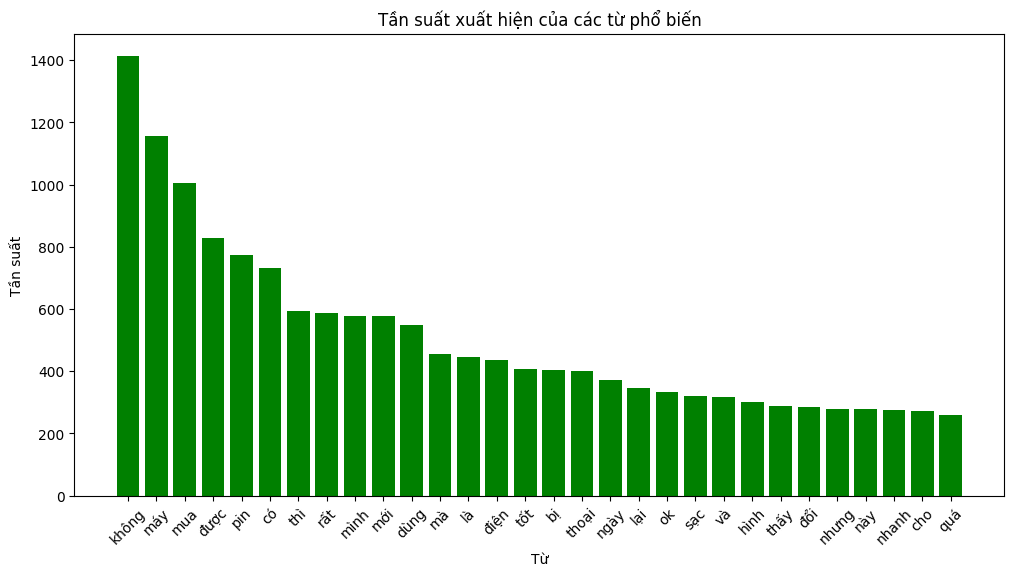

In [23]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

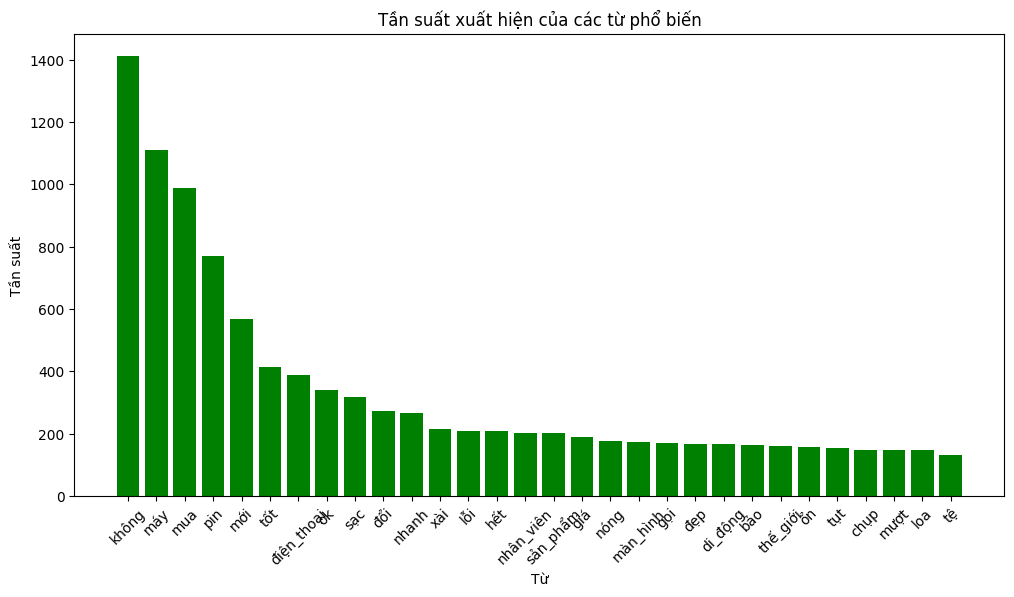

In [24]:
# Tạo biểu đồ tần suất từ
all_words = " ".join(df["comment_clean"].astype(str)).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)  # Lấy 20 từ phổ biến nhất

words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color="green")
plt.xticks(rotation=45)
plt.xlabel("Từ")
plt.ylabel("Tần suất")
plt.title("Tần suất xuất hiện của các từ phổ biến")
plt.show()

### Data before

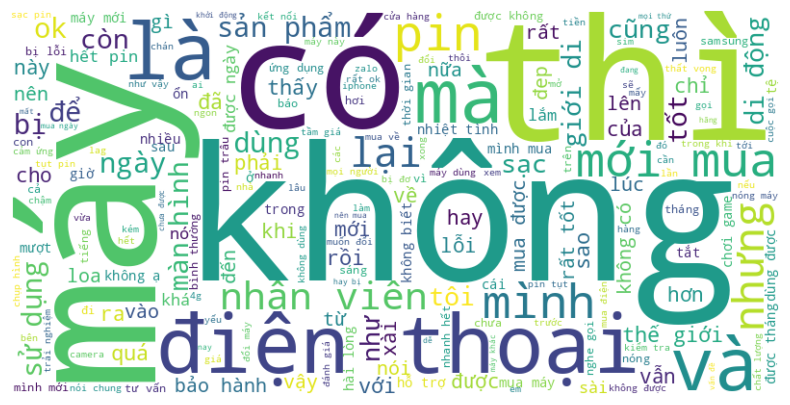

In [25]:
all_comments = " ".join(df["comment"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Data after

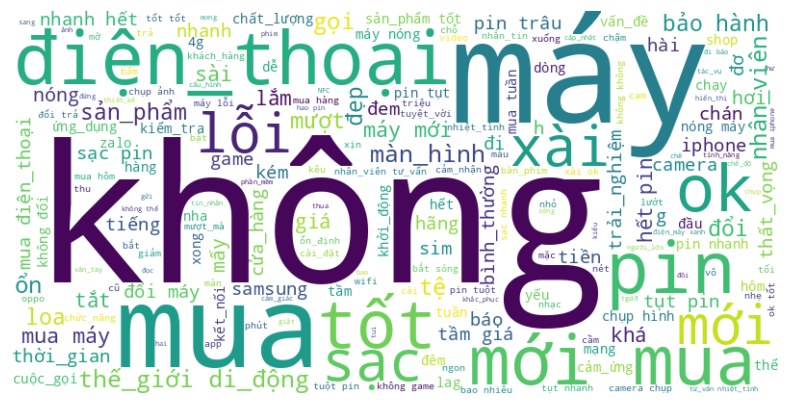

In [26]:
all_comments = " ".join(df["comment_clean"])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    all_comments
)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # No axes for word cloud
plt.show()

### Check lại kết quả sau khi tokenize
- Underthesea
![image.png](../assets/illustration/incorrect-tokenize.png)

- Cốc cốc tokenizer

![image.png](../assets/illustration/coccoc-tokenizer.png)

In [27]:
# Tìm các phần tử chứachứa từ 'pin' bên trong các bình luận ở mảng all_comments
pin_comments = set([comment for comment in all_comments.split() if "pin" in comment])
pin_comments

{'philippines', 'pin', 'đèn_pin'}

In [28]:
df.drop(columns=["word_count"], inplace=True)

In [29]:
columns = ["product_id", "comment", "comment_clean", "rating"]

df = df[columns]
df

,product_id,comment,comment_clean,rating
0,honor-x8b,đừng mua không có linh kiện,đừng mua không linh_kiện,1
1,honor-x8b,máy sao cũng được ghét nhất cái zalo vui nó bá...,máy ghét zalo vui báo hiện cuộc_gọi,3
2,honor-x8b,chiếc điện thoại mỏng nhất tôi từng dùng cũng ...,điện_thoại mỏng chip máy mượt,5
3,honor-x8b,sao hôm tôi mua lại không được tặng tai nghe n...,hôm mua không tặng tai giới_thiệu hôm đấy,4
4,honor-x8b,em mua được tuần trả lại mất bao nhiêu ạ,mua tuần trả bao nhiêu,3
...,...,...,...,...
2303,xiaomi-redmi-note-13,tôi thấy con note này chỉ mỗi pin không ổn nha...,note pin không ổn nhanh hết pin không trâu lắm...,3
2304,xiaomi-redmi-note-13,vừa mua xong thì giá giảm nên nhìn cái điện th...,mua xong giá giảm điện_thoại không ưa nổi thế_...,2
2305,xiaomi-redmi-note-13,không sử dụng cũng hao pin tối từ sáng thức dậ...,không hao pin tối thức dậy,1
2306,xiaomi-redmi-note-13,sản phẩm 3đ,sản_phẩm tệ,1


In [30]:
df.to_csv("../data/phone_ratings_cleaned.csv", index=False)